<div align="center" style="font-size: 48px; font-weight: bold;">
    Ovarian Cancer Subtype Classification
</div>

In [ ]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from PIL import Image
import cv2
import itertools
from numpy import interp
from itertools import cycle

# Import machine learning libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input


### Data Loading

In [4]:
# Set the paths for your training and testing image directories
train_dir = './Train_Images'
test_dir = './Test_Images'


### Exploratory Data Analysis(EDA)

In [ ]:
IMGE_SIZE = (224, 224)
BATCH_SIZE = 32

#  Print number of images in each class and total
print("📊 Number of images in each class (total in train_dir):")
total_images = 0
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])
        print(f"{class_name}: {num_images} images")
        total_images += num_images

print(f"\n Total number of images in all classes in train_dataset: {total_images}")

# Define the ImageDataGenerator (no validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

# Create the generator for the full dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

📊 Number of images in each class (total in train_dir):
CC: 5579 images
EC: 7421 images
HGSC: 12019 images
LGSC: 2908 images
MC: 3276 images

🧮 Total number of images in all classes in train_dataset: 31203
Found 31203 images belonging to 5 classes.


### 📌 Summary: 

- **Image Size & Batch Size**:
  - All images are resized to `(224, 224)` pixels.
  - Images are loaded in batches of size `32`.

- **Class-wise Image Count**:
  - The script loops through each subdirectory in `train_dir` (representing a class).
  - It prints the number of images in each class and the total number of training images.

- **Data Augmentation with `ImageDataGenerator`**:
  - Normalizes image pixel values (`rescale=1./255`).
  - Applies real-time data augmentation:
    - Horizontal flipping
    - Zoom transformations (up to 20%)
    - Random rotation (up to 20 degrees)

- **Training Generator**:
  - Uses `flow_from_directory` to:
    - Load images and labels from the training directory.
    - Automatically infer class labels from folder names.
    - Resize, batch, and shuffle the images for model training.


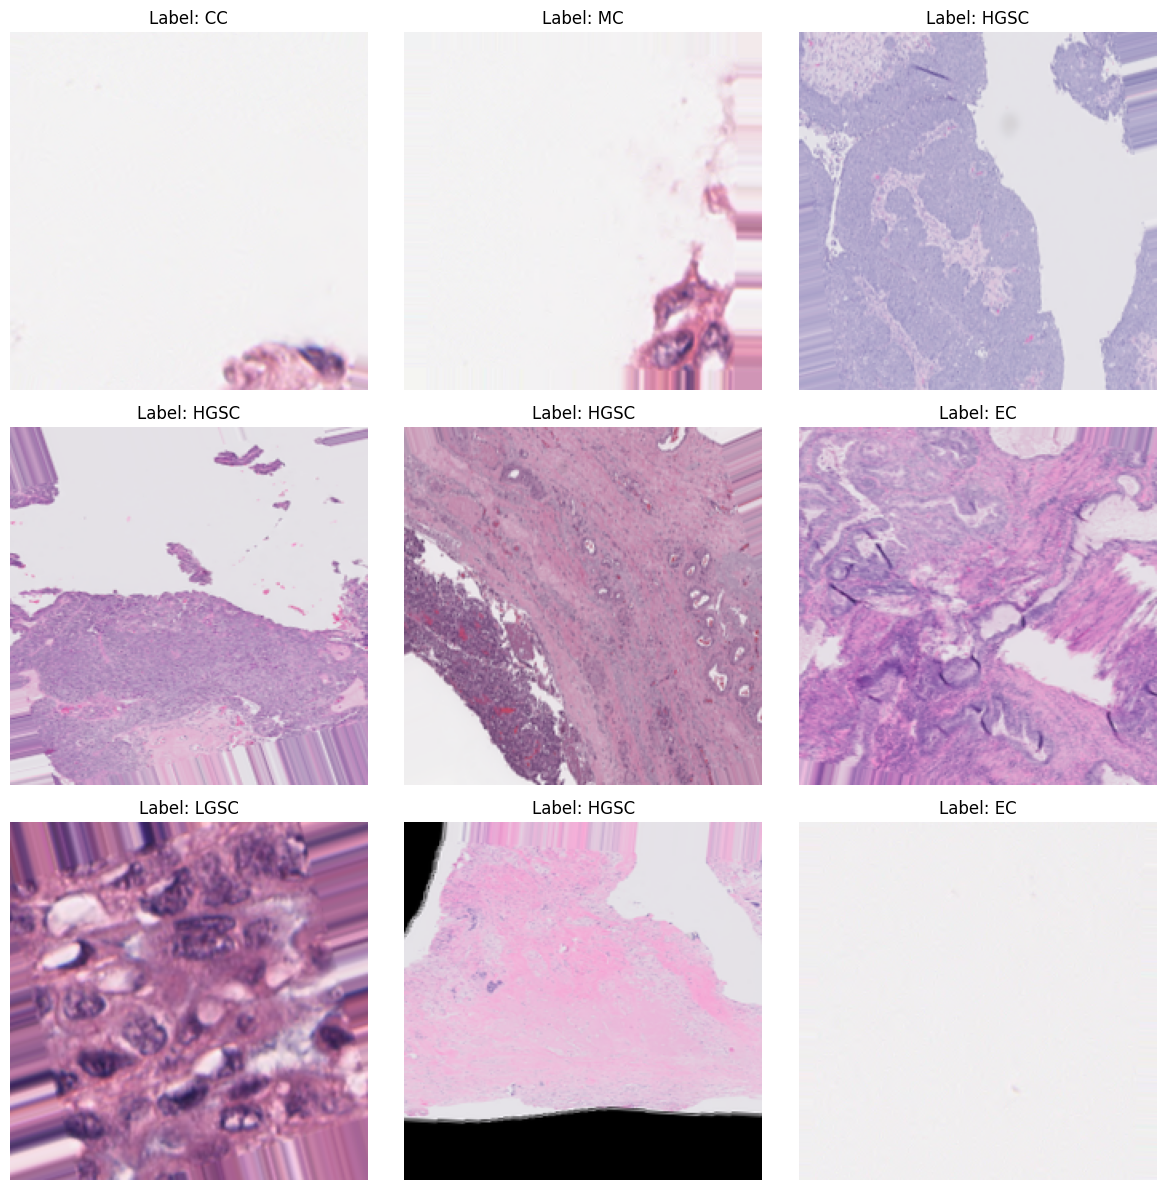

In [6]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Map class indices back to class labels
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Display the first 9 images with labels
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_label = index_to_class[np.argmax(labels[i])]
    plt.title(f"Label: {class_label}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

### 📌 Summary: 

- **Batch Extraction**:
  - Retrieves a single batch of images and their corresponding one-hot encoded labels from the training generator.

- **Class Mapping**:
  - Converts class indices back to their actual class label names using the generator's `class_indices` dictionary.

- **Image Display**:
  - Displays the first 9 images in a `3x3` grid using `matplotlib`.
  - Each image is shown with its corresponding class label as the title.
  - Axes are hidden for a cleaner visual layout.


In [7]:
# Count images per class
classes = os.listdir(train_dir)

for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")

CC: 5579 images
EC: 7421 images
HGSC: 12019 images
LGSC: 2908 images
MC: 3276 images


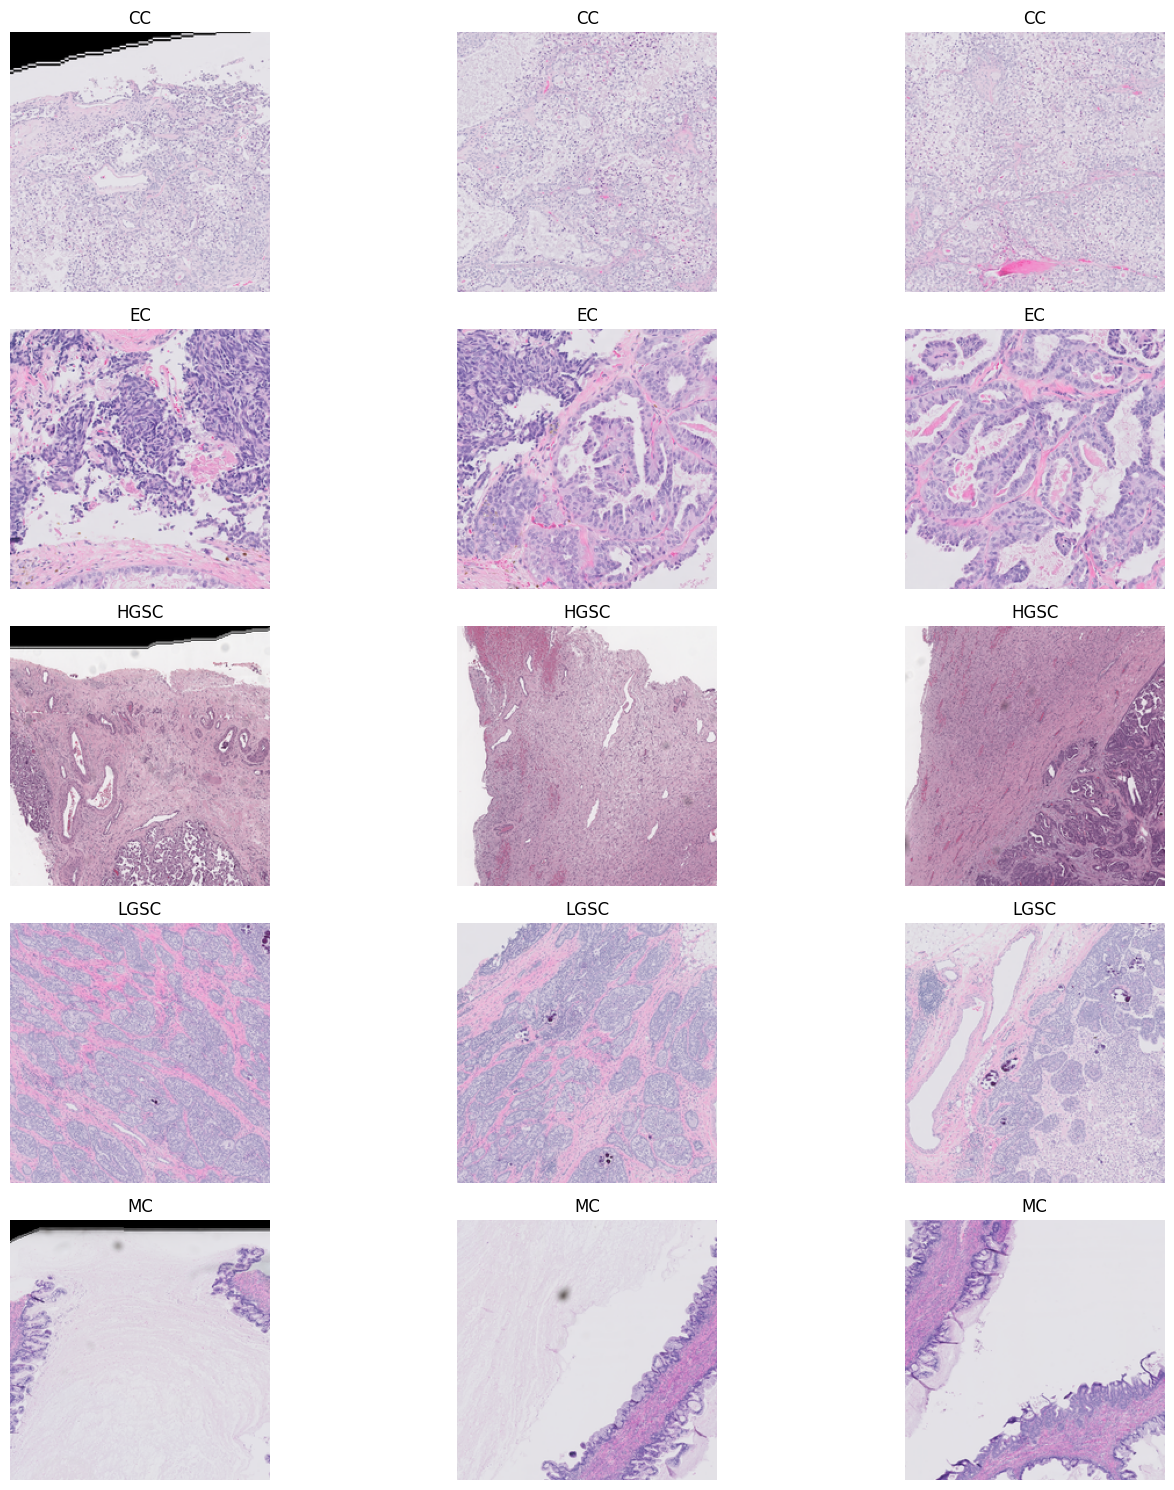

In [ ]:
train_dir = './Train_Images' 

def show_sample_images_per_class(data_dir, samples_per_class=3):
    classes = os.listdir(data_dir)
    plt.figure(figsize=(15, len(classes) * 3))

    for idx, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        images = os.listdir(cls_path)[:samples_per_class]
        
        for j, img_file in enumerate(images):
            img_path = os.path.join(cls_path, img_file)
            img = Image.open(img_path)
            plt.subplot(len(classes), samples_per_class, idx * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images_per_class(train_dir)


## Image Preprocessing

📊 Image counts per class: {'CC': 5579, 'EC': 7421, 'HGSC': 12019, 'LGSC': 2908, 'MC': 3276}


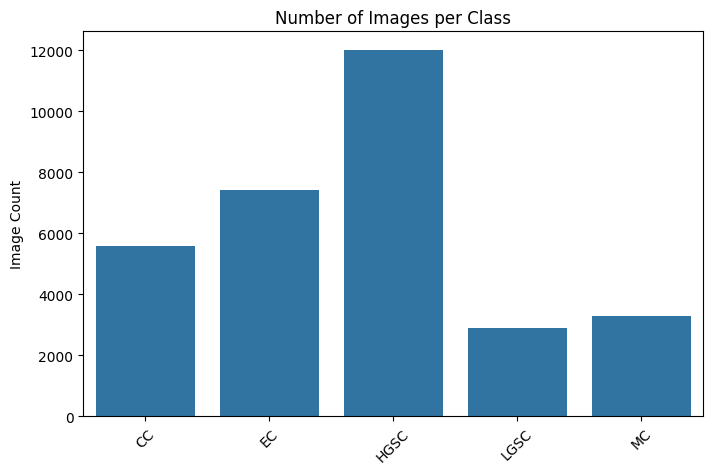

In [9]:
def count_images_per_class(data_dir):
    counts = {}
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

counts = count_images_per_class(train_dir)
print("📊 Image counts per class:", counts)

# Optional: Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title('Number of Images per Class')
plt.ylabel('Image Count')
plt.xticks(rotation=45)
plt.show()


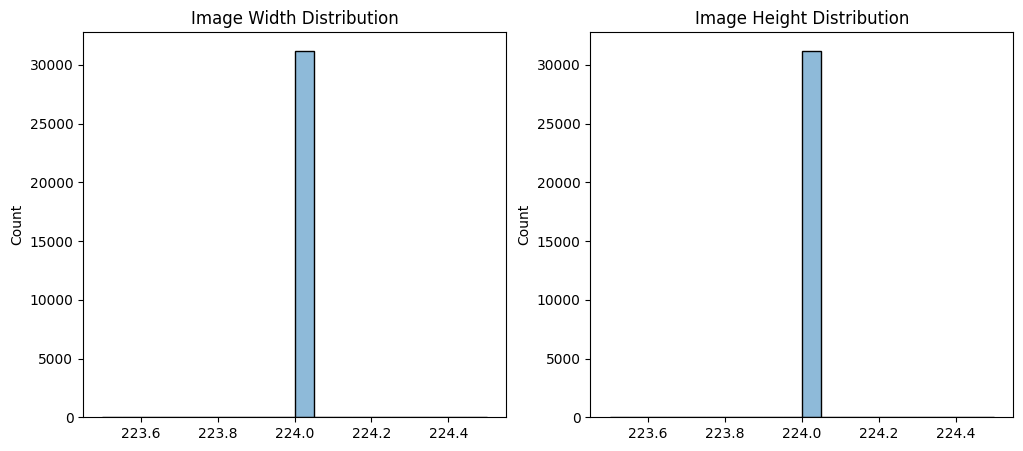

In [10]:
def get_image_dimensions(data_dir):
    heights = []
    widths = []

    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            try:
                img = Image.open(img_path)
                width, height = img.size
                widths.append(width)
                heights.append(height)
            except:
                print(f"Failed to open {img_path}")
    return widths, heights

widths, heights = get_image_dimensions(train_dir)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Image Width Distribution")
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Image Height Distribution")
plt.show()


### 📌 Summary: Image Dimension Analysis

- **Purpose**: To analyze and visualize the width and height distribution of all images in the training dataset.

- **How it works**:
  - Iterates through each class folder in `train_dir`.
  - Opens each image and extracts its width and height using the `PIL` library.
  - Collects all width and height values for statistical analysis.


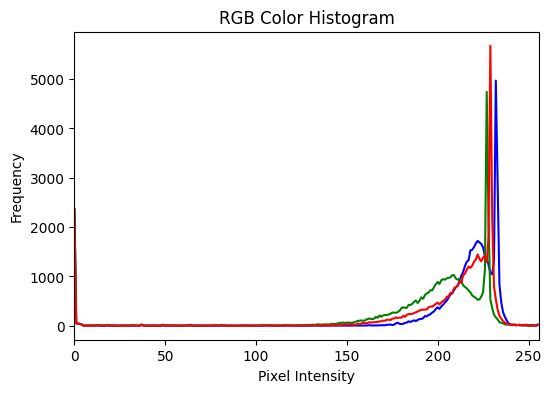

In [11]:
def plot_rgb_histogram(img_path):
    img = cv2.imread(img_path)  # Loads in BGR
    color = ('b', 'g', 'r')
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.title("RGB Color Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Example usage (change path to any image in your dataset)
example_img = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
plot_rgb_histogram(example_img)


### 📌 Summary: RGB Color Histogram Analysis

- **Purpose**: To analyze the color distribution of an image by plotting the frequency of pixel intensities for each RGB channel.

- **How it works**:
  - Loads a sample image using OpenCV (`cv2`), which reads it in BGR format.
  - Separates the image into Blue, Green, and Red channels.
  - Computes and plots the histogram of pixel intensities (0 to 255) for each channel.

- **Visualization**:
  - Each curve represents the frequency of pixel values for:
    - 🔵 Blue
    - 🟢 Green
    - 🔴 Red
  - The histogram shows that the image is **bright overall**, with most pixel intensities concentrated toward the **higher (lighter)** end of the spectrum.

-  **Conclusion**: This analysis helps understand the brightness and color balance of the image, useful for preprocessing or augmentation planning.


In [12]:
#Detect Exact Duplicates by Hashing
import hashlib

def find_duplicate_images(data_dir):
    hashes = {}
    duplicates = []

    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            try:
                with open(img_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                if file_hash in hashes:
                    duplicates.append((img_path, hashes[file_hash]))
                else:
                    hashes[file_hash] = img_path
            except:
                print(f"Error reading {img_path}")
    return duplicates

dups = find_duplicate_images(train_dir)
print(f"Found {len(dups)} duplicate images.")
for dup in dups[:5]:  # Show first few
    print("Duplicate pair:\n", dup[0], "\n", dup[1])


Found 127 duplicate images.
Duplicate pair:
 ./Train_Images\CC\22621.png 
 ./Train_Images\CC\18125.png
Duplicate pair:
 ./Train_Images\CC\22622.png 
 ./Train_Images\CC\18125.png
Duplicate pair:
 ./Train_Images\CC\22623.png 
 ./Train_Images\CC\18125.png
Duplicate pair:
 ./Train_Images\CC\22632.png 
 ./Train_Images\CC\18125.png
Duplicate pair:
 ./Train_Images\CC\22633.png 
 ./Train_Images\CC\18125.png


### 📌 Summary: Detecting Exact Duplicate Images Using Hashing

- **Purpose**: To identify and flag **exact duplicate images** in the dataset using file hashing.

- **How it works**:
  - Iterates through all image files in each class directory.
  - Reads each image in binary mode and computes its **MD5 hash**.
  - Uses a dictionary to track unique hashes:
    - If a hash already exists, it's marked as a **duplicate**.
    - If not, it's stored as a new entry.
  - Collects and returns all duplicate image pairs.

- **Output**:
  - Prints the **total number of duplicate image pairs** found.
  - Shows paths of a few example duplicates for review.

-  **Conclusion**: This method efficiently detects **bitwise-identical duplicates**, which is helpful for dataset cleaning and improving training quality.


In [13]:
#Flag Low-Quality Images (e.g., tiny dimensions)
def find_low_quality_images(data_dir, min_size=(100, 100)):
    low_quality = []
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            try:
                img = Image.open(img_path)
                if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
                    low_quality.append(img_path)
            except:
                continue
    return low_quality

low_q = find_low_quality_images(train_dir)
print(f"Found {len(low_q)} low-quality images.")


Found 0 low-quality images.


### 📌 Summary: 

**Purpose**: To detect and list **low-quality images** based on their dimensions, ensuring all images meet a minimum size requirement for model training.

- **How it works**:
  - Iterates through each image in the dataset.
  - Opens each image and checks if its **width or height is below a defined threshold** (default: 100×100 pixels).
  - Flags and stores paths of all such images.

- **Output**:
  - Prints the **number of low-resolution images** found in the dataset.

- **Conclusion**: This helps in identifying and handling tiny or corrupted images that could negatively impact model performance.


In [14]:
%pip install imagehash Pillow tqdm


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: imagehash in c:\users\user\anaconda3\envs\tf_project\lib\site-packages (4.3.2)



In [15]:
%pip install imagehash


In [16]:
import os
from PIL import Image
import imagehash
from tqdm import tqdm
import shutil
duplicate_folder = os.path.join(os.path.dirname(train_dir), '_duplicates_removed')

# 📦 Store hashes and duplicates
hashes = {}
duplicates = []

# 🧮 Count images per class and in total
def count_images(directory):
    total = 0
    class_counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path) and not cls.startswith('_'):
            imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
            class_counts[cls] = len(imgs)
            total += len(imgs)
    return total, class_counts

# 🔢 Before removing duplicates
print("📊 Before Removing Duplicates:")
total_before, class_before = count_images(train_dir)
print(f"🔢 Total images: {total_before}")
for cls, count in class_before.items():
    print(f"🗂️ {cls}: {count} images")

# 📁 Create folder to move duplicates
os.makedirs(duplicate_folder, exist_ok=True)

# 🔍 Check for duplicates using perceptual hash (pHash)
print("\n🔍 Checking for duplicates...")
for cls in tqdm(os.listdir(train_dir)):
    cls_path = os.path.join(train_dir, cls)
    if not os.path.isdir(cls_path) or cls.startswith('_'):
        continue

    for fname in os.listdir(cls_path):
        if fname.lower().endswith(('png', 'jpg', 'jpeg')):
            fpath = os.path.join(cls_path, fname)
            try:
                with Image.open(fpath) as img:
                    hash_val = str(imagehash.phash(img))
                    if hash_val in hashes:
                        # Duplicate found, move to backup folder
                        duplicates.append(fpath)
                        shutil.move(fpath, os.path.join(duplicate_folder, f"{cls}_{fname}"))
                    else:
                        hashes[hash_val] = fpath
            except Exception as e:
                print(f"❌ Error reading {fpath}: {e}")

# ✅ Summary after removing duplicates
print(f"\n🧹 Removed {len(duplicates)} duplicate images.")
print("\n📊 After Removing Duplicates:")
total_after, class_after = count_images(train_dir)
print(f"🔢 Total images: {total_after}")
for cls, count in class_after.items():
    print(f"🗂️ {cls}: {count} images")

📊 Before Removing Duplicates:
🔢 Total images: 31203
🗂️ CC: 5579 images
🗂️ EC: 7421 images
🗂️ HGSC: 12019 images
🗂️ LGSC: 2908 images
🗂️ MC: 3276 images

🔍 Checking for duplicates...


100%|██████████| 5/5 [11:19<00:00, 135.83s/it]



🧹 Removed 192 duplicate images.

📊 After Removing Duplicates:
🔢 Total images: 31011
🗂️ CC: 5557 images
🗂️ EC: 7346 images
🗂️ HGSC: 11988 images
🗂️ LGSC: 2884 images
🗂️ MC: 3236 images


### 📌 Summary: 

- **Objective**: Eliminate visually similar (perceptual) duplicates that may not be byte-for-byte identical but are effectively redundant for training.
  
- **Technique**:
  - Uses **perceptual hashing (pHash)** to generate a hash representing visual content.
  - Compares these hashes across all images.
  - Flags and removes any duplicates with matching pHash values.
  - Moves duplicates to a backup directory: `_duplicates_removed`.

- **📊 Dataset Stats**:
  - **Before Removal**:
    - Total images: `31,203`
    - CC: `5,579`, EC: `7,421`, HGSC: `12,019`, LGSC: `2,908`, MC: `3,276`
  - **After Removal**:
    - Total images: `31,011`
    - CC: `5,557`, EC: `7,346`, HGSC: `11,988`, LGSC: `2,884`, MC: `3,236`
  - **Removed**: `192` perceptual duplicates

- **Benefits**:
  - Ensures training data isn't biased by repeated visual content.
  - Reduces overfitting risk and improves model generalization.

- Duplicates are safely stored and can be reviewed later if needed.


In [17]:
import os
import shutil
import random
from tqdm import tqdm

# Define paths
train_dir =  './Train_Images' # Update this path
test_dir = './Test_Images'    # Update this path
val_size = 0.2  # 20% for validation
random.seed(42)  # For reproducibility

# Create validation directory
val_dir = os.path.join(os.path.dirname(train_dir), 'val')
os.makedirs(val_dir, exist_ok=True)

# Check if validation set already exists
val_has_data = False
if os.path.exists(val_dir):
    for cls in os.listdir(val_dir):
        cls_path = os.path.join(val_dir, cls)
        if os.path.isdir(cls_path) and len(os.listdir(cls_path)) > 0:
            val_has_data = True
            break

# Count images in directory
def count_images(directory):
    total = 0
    class_counts = {}
    
    if not os.path.exists(directory):
        return total, class_counts
        
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path) and not cls.startswith('_'):
            imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
            class_counts[cls] = len(imgs)
            total += len(imgs)
    
    return total, class_counts

# Split dataset if validation is empty
if not val_has_data:
    for cls in tqdm(os.listdir(train_dir)):
        cls_path = os.path.join(train_dir, cls)
        if not os.path.isdir(cls_path) or cls.startswith('_'):
            continue
            
        val_cls_path = os.path.join(val_dir, cls)
        os.makedirs(val_cls_path, exist_ok=True)
        
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        num_val = int(len(images) * val_size)
        val_images = random.sample(images, num_val)
        
        for img in val_images:
            shutil.move(os.path.join(cls_path, img), os.path.join(val_cls_path, img))

# Count and display results
train_total, train_counts = count_images(train_dir)
val_total, val_counts = count_images(val_dir)
test_total, test_counts = count_images(test_dir)

print(f"Train set: {train_total} images")
for cls, count in train_counts.items():
    print(f"  {cls}: {count}")

print(f"\nValidation set: {val_total} images")
for cls, count in val_counts.items():
    print(f"  {cls}: {count}")

print(f"\nTest set: {test_total} images")
for cls, count in test_counts.items():
    print(f"  {cls}: {count}")

print(f"\nTotal: {train_total + val_total + test_total} images")

Train set: 31011 images
  CC: 5557
  EC: 7346
  HGSC: 11988
  LGSC: 2884
  MC: 3236

Validation set: 6200 images
  CC: 1111
  EC: 1469
  HGSC: 2397
  LGSC: 576
  MC: 647

Test set: 3082 images
  CC: 551
  EC: 733
  HGSC: 1188
  LGSC: 287
  MC: 323

Total: 40293 images


### 📌 Summary: Dataset Splitting (Train / Validation / Test)

- **Objective**: Create a deterministic training-validation split (80/20) while preserving class balance.

- **Logic**:
  - Uses `random.seed(42)` for reproducibility.
  - For each class in the training directory:
    - 20% of images are moved to a new `val/` folder, preserving the class structure.
  - Ensures the split is **only performed if validation set is empty**, preventing accidental reshuffling.

---

#### Final Dataset Summary

| Split        | Total Images | CC   | EC   | HGSC  | LGSC | MC   |
|--------------|--------------|------|------|-------|------|------|
| **Train**    | 31,011       | 5557 | 7346 | 11,988| 2884 | 3236 |
| **Validation** | 6,200      | 1111 | 1469 | 2397  | 576  | 647  |
| **Test**     | 3,082        | 551  | 733  | 1188  | 287  | 323  |
| **Total**    | **40,293**   |      |      |       |      |      |

---

-  **Stratification preserved** across all three sets.
-  **Validation ratio**: 20% of training data.
-  Ensures **no data leakage** and consistent evaluation.



In [18]:
# 1. Data Augmentation & Preprocessing for Training
train_datagen = ImageDataGenerator(
    # Rescaling pixel values to the range [0, 1]
    rescale=1./255,
    
    # Image augmentation techniques (for training set only)
    horizontal_flip=True,  # Random horizontal flip
    zoom_range=0.2,       # Random zoom
    rotation_range=20,    # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,      # Random shearing
    fill_mode='nearest'   # Fill pixels after transformations
    # No validation_split needed as we've already split the data
)

# 2. Data Augmentation & Preprocessing for Validation and Test (no augmentation)
# Test and Validation will only have normalization (rescaling)
test_val_datagen = ImageDataGenerator(
    rescale=1./255
)

# 3. Create Training Data Generator (from train_dir)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMGE_SIZE,  # Resize images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Multi-class classification
    shuffle=True  # Shuffle the images for better generalization
)

# 4. Create Validation Data Generator (from val_dir)
val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMGE_SIZE,  # Resize images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Multi-class classification
    shuffle=False  # No shuffling for validation
)

# 5. Create Test Data Generator
test_generator = test_val_datagen.flow_from_directory(
    test_dir,  # Test data directory
    target_size=IMGE_SIZE,  # Resize images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Multi-class classification
    shuffle=False  # No shuffling for test set
)

# Count and display results
train_total, train_counts = count_images(train_dir)
val_total, val_counts = count_images(val_dir)
test_total, test_counts = count_images(test_dir)

print("\n📊 Dataset Summary:")
print(f"✅ Training set size:   {train_generator.samples} images ({train_total})")
print(f"✅ Validation set size: {val_generator.samples} images ({val_total})")
print(f"✅ Test set size:       {test_generator.samples} images ({test_total})")
print(f"🔢 Total images: {train_total + val_total + test_total}")

print("\n📊 Class Distribution:")
print("Training:")
for cls, count in train_counts.items():
    print(f"  - {cls}: {count} images")

print("\nValidation:")
for cls, count in val_counts.items():
    print(f"  - {cls}: {count} images")

print("\nTest:")
for cls, count in test_counts.items():
    print(f"  - {cls}: {count} images")

Found 31011 images belonging to 5 classes.
Found 6200 images belonging to 5 classes.
Found 3082 images belonging to 5 classes.

📊 Dataset Summary:
✅ Training set size:   31011 images (31011)
✅ Validation set size: 6200 images (6200)
✅ Test set size:       3082 images (3082)
🔢 Total images: 40293

📊 Class Distribution:
Training:
  - CC: 5557 images
  - EC: 7346 images
  - HGSC: 11988 images
  - LGSC: 2884 images
  - MC: 3236 images

Validation:
  - CC: 1111 images
  - EC: 1469 images
  - HGSC: 2397 images
  - LGSC: 576 images
  - MC: 647 images

Test:
  - CC: 551 images
  - EC: 733 images
  - HGSC: 1188 images
  - LGSC: 287 images
  - MC: 323 images


### 📌 Summary: Image Data Preprocessing & Augmentation Summary

This section prepares the dataset for training, validation, and testing using `ImageDataGenerator` with appropriate preprocessing and augmentation strategies.

---

###  1. **Training Data Augmentation**
Applied to improve generalization by generating varied versions of the training images:
- **Rescale**: Normalize pixel values to [0, 1]
- **Horizontal Flip**: Random horizontal flipping
- **Zoom Range**: 20% zoom
- **Rotation Range**: ±20 degrees
- **Width/Height Shift**: 20% random shifts
- **Shear Transformation**: 20%
- **Fill Mode**: Fill missing pixels with nearest values

---

###  2. **Validation and Test Preprocessing**
- Only normalization applied (`rescale=1./255`)
- No augmentation to ensure unbiased evaluation
- Data is not shuffled to preserve order for analysis

---
### 📊 Dataset Summary

| Set        | Size   | Classes | Shuffle | Augmentation |
|------------|--------|---------|---------|--------------|
| **Train**  | 31,011 | 5       | ✅ Yes  | ✅ Yes       |
| **Val**    | 6,200  | 5       | ❌ No   | ❌ No        |
| **Test**   | 3,082  | 5       | ❌ No   | ❌ No        |
| **Total**  | **40,293** | - | - | - |

---

###  Class-wise Image Distribution

| Class | Train | Validation | Test |
|-------|-------|------------|------|
| **CC**   | 5,557 | 1,111      | 551  |
| **EC**   | 7,346 | 1,469      | 733  |
| **HGSC** | 11,988| 2,397      | 1,188|
| **LGSC** | 2,884 | 576        | 287  |
| **MC**   | 3,236 | 647        | 323  |

---

 The dataset has been properly normalized and split with balanced class distribution across training, validation, and test sets. Data augmentation has been applied only to the training set for enhanced model generalization.


## Model evaluations 

In [19]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight


In [20]:
# Define the number of classes for ovarian cancer subtypes
no_of_classes = 5  # Update if your dataset has a different number of subtypes

# Build a CNN model optimized for medical image classification
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 3)))  # Adjusted for medical images
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolutional block
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fifth convolutional block
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling instead of Flatten for better feature extraction
model.add(GlobalAveragePooling2D())

# First dense layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Increased dropout for medical imaging

# Output layer
model.add(Dense(no_of_classes, activation='softmax'))

# Compile the model with a lower learning rate for medical imaging
opt = Adam(learning_rate=5e-5)  # Lower learning rate for better convergence
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\user\anaconda3\envs\tf_project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,65

 Total params: 1,839,813 (7.02 MB)

 Trainable params: 1,836,805 (7.01 MB)

 Non-trainable params: 3,008 (11.75 KB)

### 📌 Summary: Ovarian Cancer Subtype Classification CNN Model

This Convolutional Neural Network (CNN) model is designed for classifying ovarian cancer subtypes based on medical imaging data. The model consists of multiple convolutional layers for feature extraction, followed by dense layers for classification.

#### Model Architecture:
- **Convolutional Layers**: The model includes five convolutional blocks with increasing filter sizes (32, 64, 128, 256, 512) and batch normalization, followed by max-pooling for spatial downsampling.
- **Global Average Pooling**: Replaces flattening to better preserve spatial information and improve feature extraction.
- **Fully Connected Layers**: A dense layer with 512 units, batch normalization, activation, and dropout (50%) to prevent overfitting, followed by an output layer with 5 units (corresponding to 5 subtypes) and softmax activation for multi-class classification.

#### Hyperparameters:
- **Optimizer**: Adam optimizer with a learning rate of `5e-5` for better convergence on medical images.
- **Loss Function**: Categorical cross-entropy (suitable for multi-class classification).
- **Activation Functions**: ReLU for intermediate layers, softmax for the output layer.

#### Key Points:
- **Total Parameters**: 1,839,813 (7.02 MB), with most parameters being trainable (1,836,805).
- **Designed for Medical Imaging**: The model is optimized with a lower learning rate and dropout to handle the complexities of medical image classification.


In [21]:
# Data generators with augmentation specific for medical imaging
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # More rotation for medical images
    zoom_range=0.15,    # Slight zoom variation
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,  # Medical images can be viewed from different orientations
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define paths to your training and validation directories
train_dir = './Train_Images'  # Update with your actual path
val_dir = os.path.join(os.path.dirname(train_dir), 'val')  # Update with your actual path

# Create data generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Adjusted for medical images
    color_mode='rgb',        # Most medical images would be grayscale or RGB
    class_mode='categorical',
    batch_size=32,           # Smaller batch size for medical imaging
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 31011 images belonging to 5 classes.
Found 6200 images belonging to 5 classes.


In [ ]:
# Calculate class weights to handle class imbalance (common in medical datasets)
labels = train_gen.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights_array))
print("Computed class weights:", class_weights)

# Define callbacks with longer patience for medical imaging
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,              # More patience for medical imaging
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_ovarian_cancer_model.h5", 
    save_best_only=True, 
    monitor='val_accuracy', 
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,               # Smaller reduction factor
    patience=8,               # More patience before reducing
    min_lr=1e-7,              # Lower minimum learning rate
    verbose=1
)

# Train the model with more epochs for medical imaging tasks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,               # More epochs for medical imaging
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Computed class weights: {0: np.float64(1.1161043634727845), 1: np.float64(0.8443423515399013), 2: np.float64(0.5173808779063706), 3: np.float64(2.15), 4: np.float64(1.9166473541908073)}
Epoch 1/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6755 - loss: 0.7519
Epoch 1: val_accuracy improved from -inf to 0.52258, saving model to best_ovarian_cancer_model.h5


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1821s 1s/step - accuracy: 0.6755 - loss: 0.7519 - val_accuracy: 0.5226 - val_loss: 1.4642 - learning_rate: 1.0000e-05
Epoch 2/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.6799 - loss: 0.7411
Epoch 2: val_accuracy improved from 0.52258 to 0.52565, saving model to best_ovarian_cancer_model.h5


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1323s 853ms/step - accuracy: 0.6799 - loss: 0.7411 - val_accuracy: 0.5256 - val_loss: 1.5123 - learning_rate: 1.0000e-05
Epoch 3/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.6812 - loss: 0.7291
Epoch 3: val_accuracy improved from 0.52565 to 0.53694, saving model to best_ovarian_cancer_model.h5


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1311s 845ms/step - accuracy: 0.6812 - loss: 0.7291 - val_accuracy: 0.5369 - val_loss: 1.4687 - learning_rate: 1.0000e-05
Epoch 4/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.6846 - loss: 0.7186
Epoch 4: val_accuracy did not improve from 0.53694
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1377s 887ms/step - accuracy: 0.6846 - loss: 0.7186 - val_accuracy: 0.5284 - val_loss: 1.4581 - learning_rate: 1.0000e-05
Epoch 5/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.6860 - loss: 0.7295
Epoch 5: val_accuracy did not improve from 0.53694
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1390s 880ms/step - accuracy: 0.6860 - loss: 0.7295 - val_accuracy: 0.5102 - val_loss: 1.5136 - learning_rate: 1.0000e-05
Epoch 6/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.6994 - loss: 0.6962
Epoch 6: val_accuracy did not improve from 0.53694
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1350s 870ms/step - accuracy: 0.6994 - loss: 0.6962 - val_accuracy: 0.5018 - val_loss: 1.61

1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1211s 781ms/step - accuracy: 0.7013 - loss: 0.7033 - val_accuracy: 0.5437 - val_loss: 1.4697 - learning_rate: 1.0000e-05
Epoch 11/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.6971 - loss: 0.6982
Epoch 11: val_accuracy did not improve from 0.54371
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1441s 929ms/step - accuracy: 0.6971 - loss: 0.6982 - val_accuracy: 0.5135 - val_loss: 1.6849 - learning_rate: 1.0000e-05
Epoch 12/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.7031 - loss: 0.6884
Epoch 12: val_accuracy did not improve from 0.54371

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1418s 913ms/step - accuracy: 0.7031 - loss: 0.6884 - val_accuracy: 0.4976 - val_loss: 1.8884 - learning_rate: 1.0000e-05
Epoch 13/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7140 - loss: 0.6587
Epoch 13: val_accuracy improved from 0.54371 to 0.54597, saving model to best_ovarian_cance

1551/1551 ━━━━━━━━━━━━━━━━━━━━ 2177s 1s/step - accuracy: 0.7140 - loss: 0.6587 - val_accuracy: 0.5460 - val_loss: 1.4973 - learning_rate: 2.0000e-06
Epoch 14/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7153 - loss: 0.6606
Epoch 14: val_accuracy improved from 0.54597 to 0.54726, saving model to best_ovarian_cancer_model.h5


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 2816s 2s/step - accuracy: 0.7153 - loss: 0.6606 - val_accuracy: 0.5473 - val_loss: 1.4843 - learning_rate: 2.0000e-06
Epoch 15/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7089 - loss: 0.6681
Epoch 15: val_accuracy did not improve from 0.54726
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1668s 1s/step - accuracy: 0.7089 - loss: 0.6681 - val_accuracy: 0.5385 - val_loss: 1.5279 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 4.


### 📌 Summary: Class Weights and Model Training for Medical Imaging

In this section, **class weights** are calculated to address the class imbalance often present in medical imaging datasets, ensuring that the model places appropriate importance on each class during training.

#### Class Weights Calculation:
- The class weights are computed using the `compute_class_weight` function with the `'balanced'` option. This ensures that underrepresented classes are given more weight.
- The computed class weights are printed as a dictionary, which will be used during model training to adjust the loss function.

#### Model Callbacks:
1. **Early Stopping**:
   - Patience of 15 epochs to allow for more training time in medical imaging tasks before stopping early.
   - Restores the model weights from the epoch with the best validation loss.

2. **Model Checkpoint**:
   - Saves the model only when the validation accuracy improves, ensuring the best model is retained.

3. **Reduce Learning Rate on Plateau**:
   - Reduces the learning rate by a factor of 0.2 if the validation loss plateaus for 8 epochs, helping the model refine learning as it progresses.

#### Training:
- The model is trained for **15 epochs**, with the class weights and callbacks applied.
- Training progress is tracked, and the model's performance on both the training and validation sets is reported.
- The best model is saved after each epoch if there is an improvement in validation accuracy.

The output shows progress in the model's training, with validation accuracy improving over several epochs, especially after learning rate reduction. The model reaches a final validation accuracy of 54.73% at the end of training.


In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}")

# Save the final model
model.save("final_ovarian_cancer_model.h5")

388/388 ━━━━━━━━━━━━━━━━━━━━ 69s 178ms/step - accuracy: 0.4802 - loss: 1.6588


Validation accuracy: 0.5284
Validation loss: 1.4581


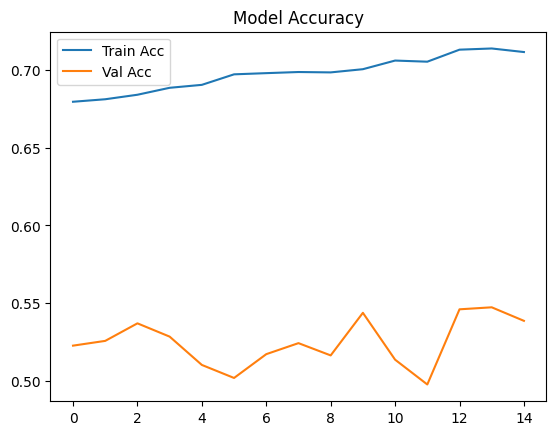

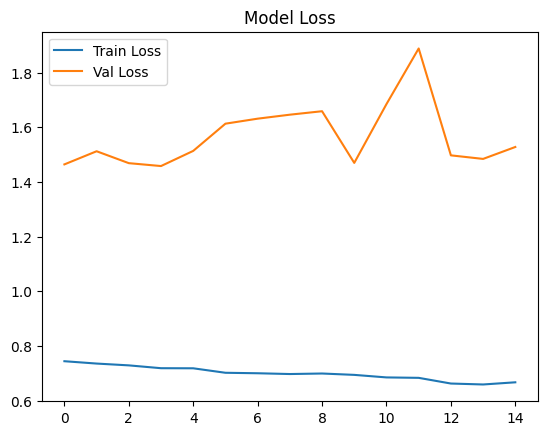

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")
plt.show()



📊 Evaluating on Train Set:
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 743s 478ms/step
Train Accuracy: 0.2259

Train Classification Report:

              precision    recall  f1-score   support

          CC       0.16      0.16      0.16      4446
          EC       0.24      0.24      0.24      5877
        HGSC       0.39      0.28      0.33      9591
        LGSC       0.09      0.15      0.11      2308
          MC       0.11      0.17      0.14      2589

    accuracy                           0.23     24811
   macro avg       0.20      0.20      0.20     24811
weighted avg       0.26      0.23      0.24     24811



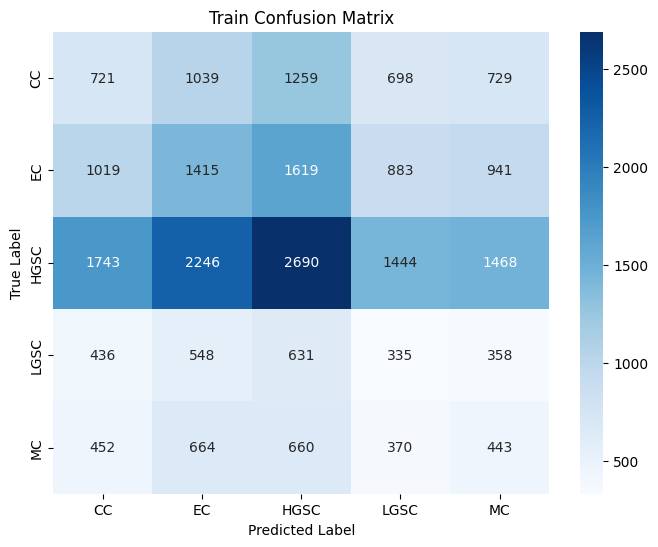


📊 Evaluating on Validation Set:
388/388 ━━━━━━━━━━━━━━━━━━━━ 61s 157ms/step
Validation Accuracy: 0.5284

Validation Classification Report:

              precision    recall  f1-score   support

          CC       0.57      0.54      0.55      1111
          EC       0.46      0.19      0.27      1469
        HGSC       0.63      0.72      0.67      2397
        LGSC       0.31      0.77      0.44       576
          MC       0.64      0.36      0.46       647

    accuracy                           0.53      6200
   macro avg       0.52      0.52      0.48      6200
weighted avg       0.55      0.53      0.51      6200



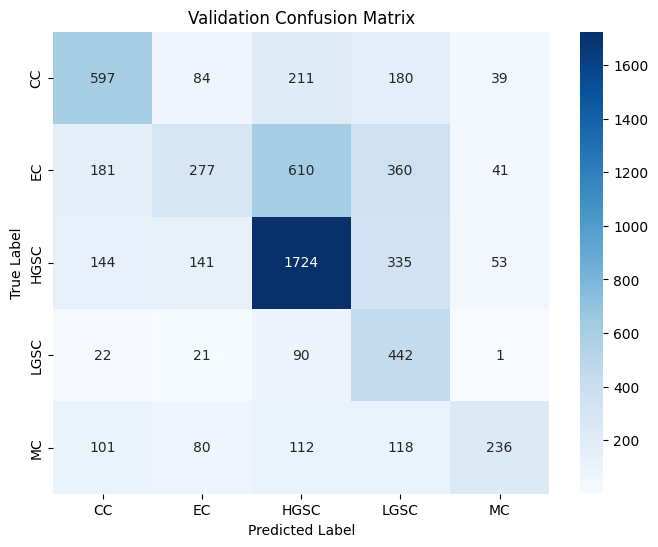

Found 3082 images belonging to 5 classes.

📊 Evaluating on Test Set:


c:\Users\user\anaconda3\envs\tf_project\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step
Test Accuracy: 0.6165

Test Classification Report:

              precision    recall  f1-score   support

          CC       0.76      0.44      0.56       551
          EC       0.63      0.50      0.56       733
        HGSC       0.66      0.79      0.72      1188
        LGSC       0.38      0.69      0.49       287
          MC       0.62      0.48      0.54       323

    accuracy                           0.62      3082
   macro avg       0.61      0.58      0.57      3082
weighted avg       0.64      0.62      0.61      3082



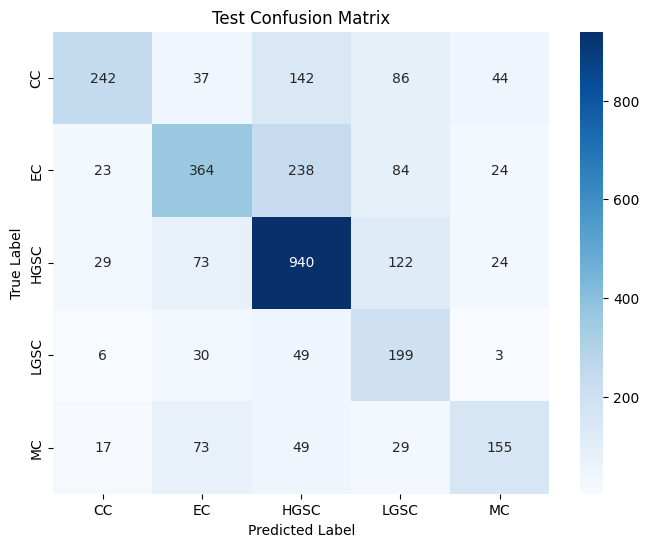

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 📌 Predict and evaluate helper function
def evaluate_model(model, data_gen, dataset_name="Validation"):
    print(f"\n📊 Evaluating on {dataset_name} Set:")
    y_true = data_gen.classes
    y_pred_probs = model.predict(data_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"{dataset_name} Accuracy: {acc:.4f}")
    
    # Classification report
    print(f"\n{dataset_name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=list(data_gen.class_indices.keys())))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(data_gen.class_indices.keys()),
                yticklabels=list(data_gen.class_indices.keys()))
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# 📌 Evaluate on train and validation sets
evaluate_model(model, train_gen, "Train")
evaluate_model(model, val_gen, "Validation")

# ✅ Create a test generator (if not already defined)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 📌 Evaluate on test set
evaluate_model(model, test_gen, "Test")
